In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import rand, lil_matrix
from itertools import product
from scipy import stats
import scipy.sparse as sparse
from scipy.sparse import random

np.random.seed(0)


## Week 5 Advanced Machine Learning: MF and BP approximation of the Ising Model

In [ ]:

n = 20  # number of spins
Jth = 0.1  # Jth sets the size of the random threshold values th
eps = 1e-13 # Define precision

def sprandsym(n, c1):
    data_rvs = stats.norm().rvs

    X = sparse.random(n, n, density=c1, data_rvs=data_rvs)
    upper_X = sparse.triu(X)
    result = upper_X + upper_X.T - sparse.diags(X.diagonal())
    return result.A

def s_all(n):
    N = 2**n
    binary_sequence = np.array([list(np.binary_repr(i, width=n)) for i in range(N)]).astype(int)
    ss = 2 * binary_sequence - 1
    return ss


def get_Ising_model(fc= True, J=0.5, n = 20, c1=0.5,  beta=0.5):

  if fc:  # toggle between full and sparse Ising network
      # Full weight matrix
      J0 = 0  # J0 and J are as defined for the SK model
      w = J0 / n + J / np.sqrt(n) * np.random.randn(n, n)
      w = w - np.diag(np.diag(w))
      w = np.tril(w) + np.tril(w).T
      c = ~(w == 0)  # neighborhood graph fully connected


  else:
    # Sparse weight matrix


    # Generate sparse symmetric weight matrix with c1*n^2 non-zero elements
    w_sparse = sprandsym(n,c1)
    w_sparse= w_sparse - np.diag(np.diag(w_sparse))
    c = ~(w_sparse== 0)  # neighborhood graph fully connected
    # Create a binary matrix based on the sign of the elements

    w = np.sign(w_sparse) * beta





  return w




In [ ]:
# Mean Field approximation
def mean_field_approximation(w, th, n, smoothing=0.5):

    m_mf = np.random.rand(n)  # Initialize m_mf at random

    iter_count = 0
    dm = 10e-3
    while(dm > eps and iter_count < 1000):
        iter_count += 1
        m_old = m_mf.copy()

        m_mf = smoothing * m_old + (1-smoothing) * np.tanh(w @ m_old+ th)
        dm = np.max(np.abs(m_mf - m_old))

    return m_mf, iter_count



def m_ij(x_j, w_ij, theta_i, a_ki):
    return 2 * np.cosh(w_ij * x_j + theta_i + np.sum(a_ki))

def get_Z(w, a, thetas,s_all):

    """

      This code computes the normalization constants for the marginal probabilities
      of 2 spins and stores them in the matrix Z


      INPUT:
      - w, (np.ndarray, shape=(n,n))
      - a, (np.ndarray, shape(n,n)
      - thetas, (np.ndarray, shape=(n))
      - s_all (OBSOLETE)


    """
    Z = np.zeros((w.shape[0], w.shape[1]))
    spin_values = [-1, 1]

    for i in range(w.shape[0]):
      for j in range(w.shape[1]):
        Z_ij = 0
        a_ki = a[:,i].copy()


        a_lj = a[:,j].copy()

        if i!=j:
          # In this case, the marginal probability is a bivariate distribution for spin i and j
          a_ki[j] = 0
          a_lj[i] = 0
          for x_i in spin_values:
              for x_j in spin_values:

                  Z_ij += np.exp(w[i,j]*x_i*x_j+ thetas[i]*x_i+ thetas[j]*x_j + np.sum(x_i*a_ki) + np.sum(x_j*a_lj))
        else:
          # In this case, the marginal probability is a univariate distribution for spin i
          for x_i in spin_values:
            Z_ij += np.exp(thetas[i]* x_i + np.sum(x_i * a_ki))

        Z[i,j] = Z_ij
    return Z



def b_ij(x_i, x_j, i,j, w, a, thetas):

    a_ki = a[:,i].copy()

    a_lj = a[:,j].copy()
    if i!=j:
      # In this case, the marginal probability is a bivariate distribution for spin i and j
      a_ki[j] = 0
      a_lj[i] = 0
      b = np.exp(w[i,j]*x_i*x_j+ thetas[i]*x_i + thetas[j]*x_j + np.sum(x_i*a_ki) + np.sum(x_j*a_lj))
    else:
      # In this case, the marginal probability is an univariate distribution for spin i
      b = np.exp(thetas[i]* x_i + np.sum(x_i * a_ki))

    return b

# Belief Propagation approximation
def belief_propagation_approximation(w, th, n, smoothing = False, mu=0.5):

    a = np.random.rand(n,n)
    da = 1
    iter_bp = 0
    while da > eps and iter_bp < 1000:
      iter_bp += 1
      a_old = a.copy()
      m_pos = np.zeros((n,n))
      m_neg = np.zeros((n,n))
      for i in range(n):
          for j in range(n):
              # Compute m_ij for positive and negative messages

              a_column = a_old[:,i].copy()
              a_column[j] = 0
              m_pos[i, j] = m_ij(1, w[i, j], th[i], a_column )
              m_neg[i, j] = m_ij(-1, w[i, j], th[i], a_column )



      # Update a using the belief propagation rule
      if smoothing == False:
        a =  0.5 * np.log(m_pos / m_neg)
      else:
        a = mu * a_old + 0.5 * (1-mu) * np.log(m_pos / m_neg)


      # Calculate the maximum absolute difference between a and a_old
      da = np.max(np.abs(a - a_old))

    m_bp = np.zeros(n)
    for i in range(n):
        m_bp[i]= np.tanh(th[i]+ np.sum(a[:,i]))

    return m_bp, iter_bp, a

def compute_correlations_bp(w, a, m_bp, thetas, s_all):

  chi_bp =np.zeros((w.shape[0], w.shape[1]))
  # Possible values for spins
  spin_values = [-1, 1]

  # Compute Z, matrix containing normalization constants of marginal distributions
  Z = get_Z(w,a, thetas, s_all)
  for i in range(w.shape[0]):
    for j in range(w.shape[1]):



      chi_i_j =0

      if i!=j:
        # Compute the correlation for spins i,j
        for x_i in spin_values:
            for x_j in spin_values:

                chi_i_j += (x_i * x_j * b_ij(x_i, x_j, i, j, w, a, thetas ) / Z[i,j] )
        chi_i_j -=  m_bp[i] * m_bp[j]
      else:
        # Compute variance for spin i
        for x_i in spin_values:
          chi_i_j += (x_i**2 * b_ij(x_i, x_i,  i, j, w, a, thetas ) / Z[i,j] )
        chi_i_j -=  m_bp[i]**2
      chi_bp[i,j] = chi_i_j
  return chi_bp

def compute_correlations_mf(w, m, thetas):

  A = np.zeros((w.shape[0], w.shape[1]))
  for i in range(w.shape[0]):
    for j in range(w.shape[1]):

       if i == j:
          A[i, j] = (1 / (1 - m[i]**2) )- w[i, j]
       else:
          A[i, j] = -w[i, j]

  chi_mf = np.linalg.inv(A)
  return chi_mf


# Define the function to calculate RMS error

def calculate_rms_error(m_approx, m_ex, n):
    return np.sqrt(np.sum((m_approx - m_ex)**2)/ n)



# MF and BP for Fully Connected Ising Model


Consider the fully connected Ising model ($c = 1$) with $n = 20, J_0 = 0, J_{th} = J = β$.

A) Compute the RMS error in the mean values $<x_i>$ as
$RMF = \sqrt{\frac{1}{n} \sum_{i=1}^n (m_i^{ex} - m_i^{mf})^2}$

with $m_i^{ex} = <x_i>$ the exact spin expectation values and $m_i^{mf}$
their MF approximations, and similar for BP.
For each β, estimate the RMS errors in
multiple random instances of the Ising model and compute the mean and
standard deviation.
Plot the RMS errors (mean and standard deviation) as
a function of β for $0 < β ≤ 2$. You should find that the algorithms converge
in several hundred iterations using smoothing $η = 0.5$. You should find that
the MF and BP results look somewhat like fig. 1

B) Compute the RMS error in the correlations $χ_{ij}$
using the
MF approximation with linear response correction $χ_{ij}^{LR}$ and
$χ_{ij}^{BP}$

In [ ]:
num_iterations = 10

# Initialize the range of beta values and the lists to store RMS errors and iterations
beta_values = np.linspace(0.1, 2, 15)
rms_errors_mf = np.zeros((beta_values.shape[0], num_iterations))
rms_errors_bp = np.zeros((beta_values.shape[0], num_iterations))
iterations_mf =np.zeros((beta_values.shape[0], num_iterations))
iterations_bp = np.zeros((beta_values.shape[0], num_iterations))

# Initialize the lists to store RMS errors in chi
rms_errors_chi_mf = np.zeros((beta_values.shape[0], num_iterations))
rms_errors_chi_bp = np.zeros((beta_values.shape[0], num_iterations))

# Calculate the RMS error for each beta value
for i,beta in enumerate(beta_values):
    for j in range(num_iterations):

      print(f'Run for iteration number {j+1}, beta = {beta}')
      w = get_Ising_model(fc=True, J = beta, n = 20)


      th = np.random.randn(n) * beta

      sa = s_all(n) # all 2^n spin configurations
      Ea = 0.5 * np.sum(sa @ np.array(w) * sa, axis=1) + sa @ th
      Ea = np.exp(Ea)
      Z = np.sum(Ea)
      p_ex = Ea / Z  # probabilities of all 2^n configurations
      m_ex = sa.T @ p_ex  # exact mean values of n spins


      # Computing exact correlations

      first_product = p_ex.reshape(-1, 1) @ np.ones((1, n))
      klad= first_product * sa
      m_col = m_ex.reshape(-1, 1)
      chi_ex = sa.T @ klad - m_col @ m_col.T # exact connected correlations





      # Calculate the MF approximation
      m_mf, iter_mf = mean_field_approximation(w, th, n)

      # Calculate the RMS error in mean values for MF
      rms_error_mf = calculate_rms_error(m_mf, m_ex, 20)

      # Compute the correlations for MF
      chi_mf = compute_correlations_mf(w,  m_mf, th)

      # Calculate the RMS error in chi for MF
      rms_error_chi_mf = calculate_rms_error(chi_mf, chi_ex, 400)

      print('rms_error_chi_mf', rms_error_chi_mf)

      rms_errors_mf[i,j]=rms_error_mf
      iterations_mf[i,j]=iter_mf
      rms_errors_chi_mf[i,j]=rms_error_chi_mf


      # Calculate the BP approximation
      m_bp, iter_bp, a = belief_propagation_approximation(w, th, n)

      # Calculate the RMS error in mean values for BP
      rms_error_bp = calculate_rms_error(m_bp, m_ex, 20)

      # Compute the correlations for BP
      chi_bp = compute_correlations_bp(w, a, m_bp, th, sa)

      # Calculate the RMS error in chi for BP
      rms_error_chi_bp = calculate_rms_error(chi_bp, chi_ex, 400)

      print('rms_error_chi_bp', rms_error_chi_bp)
      rms_errors_bp[i,j]=rms_error_bp
      iterations_bp[i,j]=iter_bp
      rms_errors_chi_bp[i,j]=rms_error_chi_bp



Run for iteration number 1, beta = 0.1
rms_error_chi_mf 0.0023021002400941916
rms_error_chi_bp 0.0018598206817960566
Run for iteration number 2, beta = 0.1
rms_error_chi_mf 0.0026931139137181736
rms_error_chi_bp 0.0020404504897930968
Run for iteration number 3, beta = 0.1
rms_error_chi_mf 0.0019103297759820264
rms_error_chi_bp 0.0016701751446113434
Run for iteration number 4, beta = 0.1
rms_error_chi_mf 0.0025873122982067896
rms_error_chi_bp 0.0020594752238239393
Run for iteration number 5, beta = 0.1
rms_error_chi_mf 0.002477453293030728
rms_error_chi_bp 0.002127859396050516
Run for iteration number 6, beta = 0.1
rms_error_chi_mf 0.0024109868893211098
rms_error_chi_bp 0.002148085769703799
Run for iteration number 7, beta = 0.1
rms_error_chi_mf 0.0020167667782650524
rms_error_chi_bp 0.001792084316805388
Run for iteration number 8, beta = 0.1
rms_error_chi_mf 0.0020480059417849836
rms_error_chi_bp 0.0016994809979410024
Run for iteration number 9, beta = 0.1
rms_error_chi_mf 0.0025145157

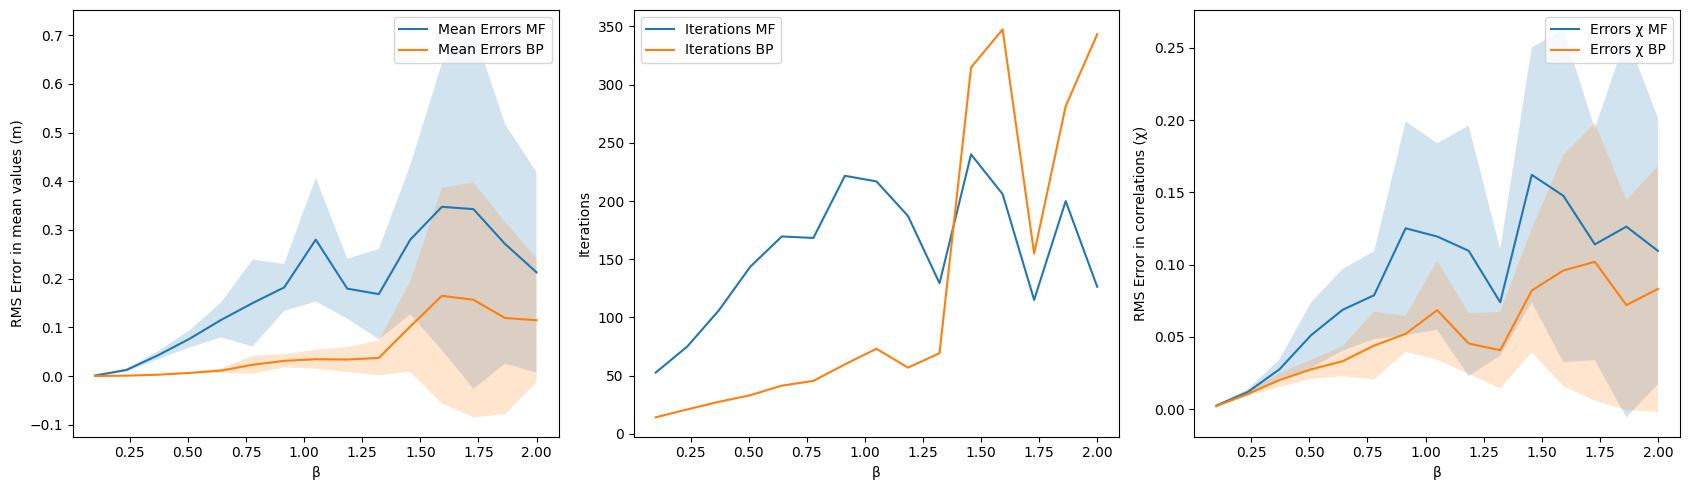

In [ ]:


# Assuming you have calculated std for each case (mf, bp, chi_mf, chi_bp)
std_mf = np.std(rms_errors_mf, axis=1)
std_bp = np.std(rms_errors_bp, axis=1)
std_chi_mf = np.std(rms_errors_chi_mf, axis=1)
std_chi_bp = np.std(rms_errors_chi_bp, axis=1)

plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
plt.plot(beta_values, np.mean(rms_errors_mf, axis=1), label='Mean Errors MF')
plt.plot(beta_values, np.mean(rms_errors_bp, axis=1), label='Mean Errors BP')
plt.fill_between(beta_values, np.mean(rms_errors_mf, axis=1) - std_mf, np.mean(rms_errors_mf, axis=1) + std_mf, alpha=0.2)
plt.fill_between(beta_values, np.mean(rms_errors_bp, axis=1) - std_bp, np.mean(rms_errors_bp, axis=1) + std_bp, alpha=0.2)
plt.xlabel('β')
plt.ylabel('RMS Error in mean values (m)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(beta_values, np.mean(iterations_mf, axis=1), label='Iterations MF')
plt.plot(beta_values, np.mean(iterations_bp, axis=1), label='Iterations BP')
plt.xlabel('β')
plt.ylabel('Iterations')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(beta_values, np.mean(rms_errors_chi_mf, axis=1), label='Errors χ MF')
plt.plot(beta_values, np.mean(rms_errors_chi_bp, axis=1), label='Errors χ BP')
plt.fill_between(beta_values, np.mean(rms_errors_chi_mf, axis=1) - std_chi_mf, np.mean(rms_errors_chi_mf, axis=1) + std_chi_mf, alpha=0.2)
plt.fill_between(beta_values, np.mean(rms_errors_chi_bp, axis=1) - std_chi_bp, np.mean(rms_errors_chi_bp, axis=1) + std_chi_bp, alpha=0.2)
plt.xlabel('β')
plt.ylabel('RMS Error in correlations (χ)')
plt.legend()

plt.tight_layout()
plt.show()


# MF and BP for Sparse Ising Model

C) Consider the sparse Ising model with $n = 20$ and sparsity $c$ with non-zero couplings $w = ±β$.
Put all threshold values equal to $θ > 0$. Plot the RMS errors
(mean and standard deviation) as a function of $c, β $ for $0 < c ≤ 1$ and $0 < β ≤ 1$
and for various $θ$.
You should find that the BP results are more accurate than
MF for sparse networks.

## Results as a function of c for $\theta = 0.1$

In [ ]:
n=20
n_iter = 10

# Initialize the range of beta and c values and the lists to store RMS errors and iterations
line_values = np.linspace(0.1, 1, 7)

# Possible values of theta: 0,1 - 0,5 - 0.9
theta_values = [0.1]

# Values of beta to test
betas = np.linspace(0.2, 0.5, num=2)



theta_results_bp_c = []
theta_results_mf_c = []
theta_dev_bp_c = []
theta_dev_mf_c = []
iterations_results_bp_c = []
iterations_results_mf_c = []


for k, theta_val in enumerate(theta_values):

  rms_errors_mf_c = np.zeros((line_values.shape[0], len(betas)))
  rms_errors_bp_c = np.zeros((line_values.shape[0], len(betas)))
  rms_dev_errors_mf_c = np.zeros((line_values.shape[0], len(betas)))
  rms_dev_errors_bp_c = np.zeros((line_values.shape[0], len(betas)))
  iterations_mf_c = np.zeros((line_values.shape[0], len(betas)))
  iterations_bp_c = np.zeros((line_values.shape[0], len(betas)))

  for i, val in enumerate(line_values):


    for j, beta in enumerate(betas):
      errors_for_beta_mf = []
      iter_for_beta_mf = []
      errors_for_beta_bp = []
      iter_for_beta_bp = []

      for _ in range(n_iter):
        print(f'Theta {theta_val} - c = {val} - beta = {beta} - iter {_}')
        w = get_Ising_model(fc=False, beta=beta, c1=val)
        th = np.ones(n) * theta_val
        sa = s_all(n) # all 2^n spin configurations
        Ea = 0.5 * np.sum(sa @ np.array(w) * sa, axis=1) + sa @ th
        Ea = np.exp(Ea)
        Z = np.sum(Ea)
        p_ex = Ea / Z  # probabilities of all 2^n configurations
        m_ex = sa.T @ p_ex  # exact mean values of n spins


        # Calculate the MF approximation
        m_mf, iter_mf = mean_field_approximation(w, th, n)
        rms_error_mf = calculate_rms_error(m_mf, m_ex,20)  # Calculate the RMS error
        errors_for_beta_mf.append(rms_error_mf)
        iter_for_beta_mf.append(iter_mf)


        # Calculate the BP approximation
        m_bp, iter_bp, _ = belief_propagation_approximation(w=w, th=th, n=n, smoothing = True, mu=0.5)
        rms_error_bp = calculate_rms_error(m_bp, m_ex,400)  # Calculate the RMS error
        errors_for_beta_bp.append(rms_error_bp)
        iter_for_beta_bp.append(iter_bp)

      rms_errors_mf_c[i,j] = np.mean(errors_for_beta_mf)
      rms_errors_bp_c[i,j] = np.mean(errors_for_beta_bp)

      rms_dev_errors_mf_c[i,j] = np.std(errors_for_beta_mf)
      rms_dev_errors_bp_c[i,j] = np.std(errors_for_beta_bp)

      iterations_mf_c[i,j] = np.mean(iter_for_beta_mf)
      iterations_bp_c[i,j] = np.mean(iter_for_beta_bp)

  theta_results_bp_c.append(rms_errors_bp_c)
  theta_results_mf_c.append(rms_errors_mf_c)
  theta_dev_bp_c.append(rms_dev_errors_bp_c)
  theta_dev_mf_c.append(rms_dev_errors_mf_c)
  iterations_results_bp_c.append(iterations_bp_c)
  iterations_results_mf_c.append(iterations_mf_c)



Plots for $\theta = 0.1$ and $\beta = 0.2$

Plots for theta with index = 0
[0.00015037 0.00047789 0.00147332 0.00415305 0.00545085 0.00625443
 0.00836596]


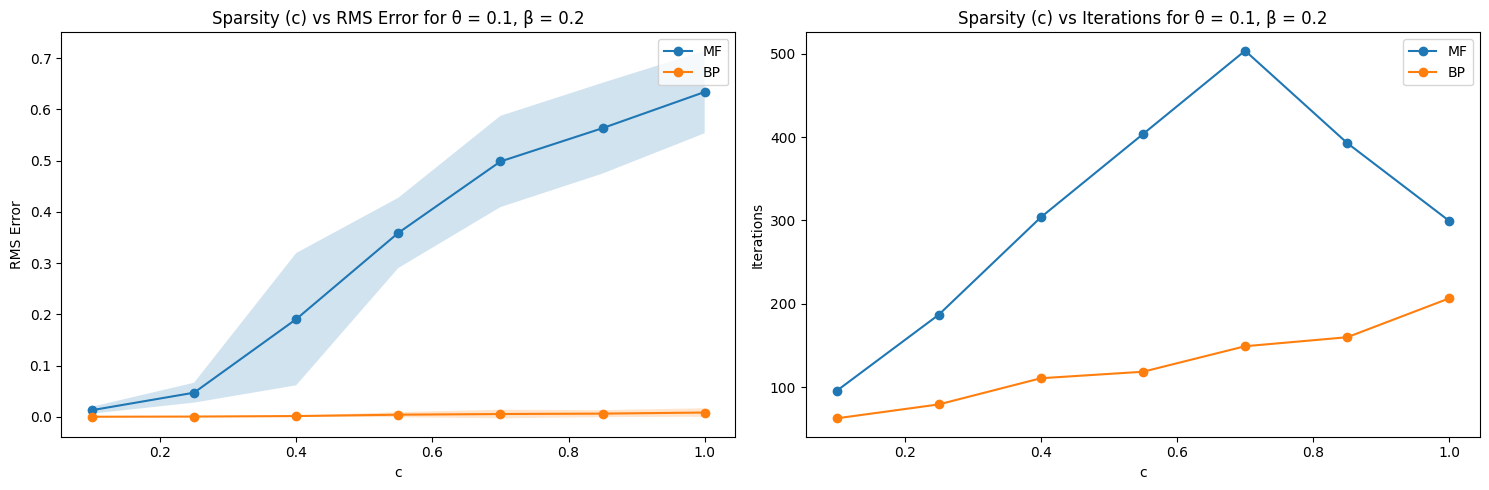

In [ ]:

index_theta = 0
index_beta = 0
print(f'Plots for theta with index = {index_theta}')

error_bp = theta_results_bp_c[index_theta][:, index_beta]
print(error_bp)
error_mf = theta_results_mf_c[index_theta][:,index_beta]

iter_bp = iterations_results_bp_c[index_theta][:,index_beta]
iter_mf = iterations_results_mf_c[index_theta][:, index_beta]

# Calculate standard deviation for both errors and iterations
std_error_bp = theta_dev_bp_c[index_theta][:,index_beta]
std_error_mf = theta_dev_mf_c[index_theta][:,index_beta]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('c')
plt.ylabel('RMS Error')
plt.title('Sparsity (c) vs RMS Error for θ = 0.1, β = 0.2')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')
plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('c')
plt.ylabel('Iterations')
plt.title('Sparsity (c) vs Iterations for θ = 0.1, β = 0.2')
plt.legend()

plt.tight_layout()
plt.show()


Plots for $\theta = 0.1$, $\beta = 0.5$

Plots for theta with index = 0


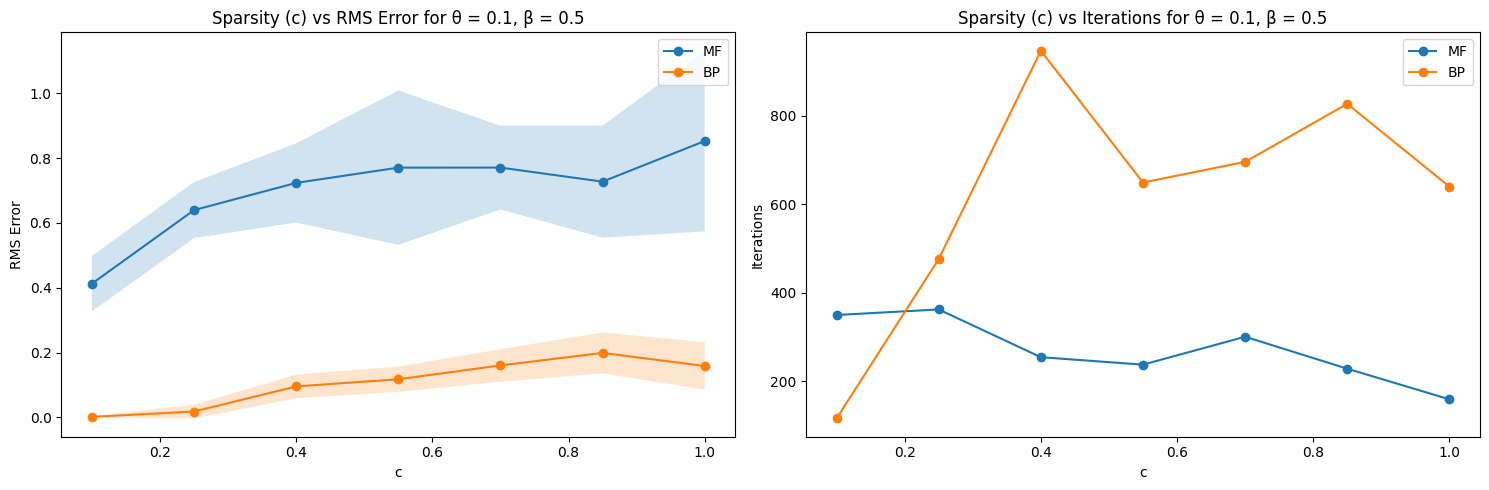

In [ ]:

index_theta = 0
index_beta = 1
print(f'Plots for theta with index = {index_theta}')

error_bp = theta_results_bp_c[index_theta][:, index_beta]
error_mf = theta_results_mf_c[index_theta][:,index_beta]

iter_bp = iterations_results_bp_c[index_theta][:,index_beta]
iter_mf = iterations_results_mf_c[index_theta][:, index_beta]

# Calculate standard deviation for both errors and iterations
std_error_bp = theta_dev_bp_c[index_theta][:,index_beta]
std_error_mf = theta_dev_mf_c[index_theta][:,index_beta]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('c')
plt.ylabel('RMS Error')
plt.title('Sparsity (c) vs RMS Error for θ = 0.1, β = 0.5')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')
plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('c')
plt.ylabel('Iterations')
plt.title('Sparsity (c) vs Iterations for θ = 0.1, β = 0.5')
plt.legend()

plt.tight_layout()
plt.show()


## Results as a function of c for $\theta = 0.5$

In [ ]:
n=20
n_iter = 10

# Initialize the range of beta and c values and the lists to store RMS errors and iterations
line_values = np.linspace(0.1, 1, 7)

# Possible values of theta: 0,1 - 0,5 - 0.9
theta_values = [0.5]

# Values of beta to test
betas = np.linspace(0.2, 0.5, num=2)


theta_results_bp_c = []
theta_results_mf_c = []
theta_dev_bp_c = []
theta_dev_mf_c = []
iterations_results_bp_c = []
iterations_results_mf_c = []


for k, theta_val in enumerate(theta_values):

  rms_errors_mf_c = np.zeros((line_values.shape[0], len(betas)))
  rms_errors_bp_c = np.zeros((line_values.shape[0], len(betas)))
  rms_dev_errors_mf_c = np.zeros((line_values.shape[0], len(betas)))
  rms_dev_errors_bp_c = np.zeros((line_values.shape[0], len(betas)))
  iterations_mf_c = np.zeros((line_values.shape[0], len(betas)))
  iterations_bp_c = np.zeros((line_values.shape[0], len(betas)))

  for i, val in enumerate(line_values):


    for j, beta in enumerate(betas):
      errors_for_beta_mf = []
      iter_for_beta_mf = []
      errors_for_beta_bp = []
      iter_for_beta_bp = []

      for _ in range(n_iter):
        print(f'Theta {theta_val} - c = {val} - beta = {beta} - iter {_}')
        w = get_Ising_model(fc=False, beta=beta, c1=val)
        th = np.ones(n) * theta_val
        sa = s_all(n) # all 2^n spin configurations
        Ea = 0.5 * np.sum(sa @ np.array(w) * sa, axis=1) + sa @ th
        Ea = np.exp(Ea)
        Z = np.sum(Ea)
        p_ex = Ea / Z  # probabilities of all 2^n configurations
        m_ex = sa.T @ p_ex  # exact mean values of n spins


        # Calculate the MF approximation
        m_mf, iter_mf = mean_field_approximation(w, th, n)
        rms_error_mf = calculate_rms_error(m_mf, m_ex,20)  # Calculate the RMS error
        errors_for_beta_mf.append(rms_error_mf)
        iter_for_beta_mf.append(iter_mf)


        # Calculate the BP approximation
        m_bp, iter_bp, _ = belief_propagation_approximation(w=w, th=th, n=n, smoothing = True, mu=0.5)
        rms_error_bp = calculate_rms_error(m_bp, m_ex,400)  # Calculate the RMS error
        errors_for_beta_bp.append(rms_error_bp)
        iter_for_beta_bp.append(iter_bp)

      rms_errors_mf_c[i,j] = np.mean(errors_for_beta_mf)
      rms_errors_bp_c[i,j] = np.mean(errors_for_beta_bp)

      rms_dev_errors_mf_c[i,j] = np.std(errors_for_beta_mf)
      rms_dev_errors_bp_c[i,j] = np.std(errors_for_beta_bp)

      iterations_mf_c[i,j] = np.mean(iter_for_beta_mf)
      iterations_bp_c[i,j] = np.mean(iter_for_beta_bp)

  theta_results_bp_c.append(rms_errors_bp_c)
  theta_results_mf_c.append(rms_errors_mf_c)
  theta_dev_bp_c.append(rms_dev_errors_bp_c)
  theta_dev_mf_c.append(rms_dev_errors_mf_c)
  iterations_results_bp_c.append(iterations_bp_c)
  iterations_results_mf_c.append(iterations_mf_c)



Theta 0.5 - c = 0.1 - beta = 0.2 - iter 0
Theta 0.5 - c = 0.1 - beta = 0.2 - iter 1
Theta 0.5 - c = 0.1 - beta = 0.2 - iter 2
Theta 0.5 - c = 0.1 - beta = 0.2 - iter 3
Theta 0.5 - c = 0.1 - beta = 0.2 - iter 4
Theta 0.5 - c = 0.1 - beta = 0.2 - iter 5
Theta 0.5 - c = 0.1 - beta = 0.2 - iter 6
Theta 0.5 - c = 0.1 - beta = 0.2 - iter 7
Theta 0.5 - c = 0.1 - beta = 0.2 - iter 8
Theta 0.5 - c = 0.1 - beta = 0.2 - iter 9
Theta 0.5 - c = 0.1 - beta = 0.5 - iter 0
Theta 0.5 - c = 0.1 - beta = 0.5 - iter 1
Theta 0.5 - c = 0.1 - beta = 0.5 - iter 2
Theta 0.5 - c = 0.1 - beta = 0.5 - iter 3
Theta 0.5 - c = 0.1 - beta = 0.5 - iter 4
Theta 0.5 - c = 0.1 - beta = 0.5 - iter 5
Theta 0.5 - c = 0.1 - beta = 0.5 - iter 6
Theta 0.5 - c = 0.1 - beta = 0.5 - iter 7
Theta 0.5 - c = 0.1 - beta = 0.5 - iter 8
Theta 0.5 - c = 0.1 - beta = 0.5 - iter 9
Theta 0.5 - c = 0.25 - beta = 0.2 - iter 0
Theta 0.5 - c = 0.25 - beta = 0.2 - iter 1
Theta 0.5 - c = 0.25 - beta = 0.2 - iter 2
Theta 0.5 - c = 0.25 - beta = 0

Plots for theta with index = 0


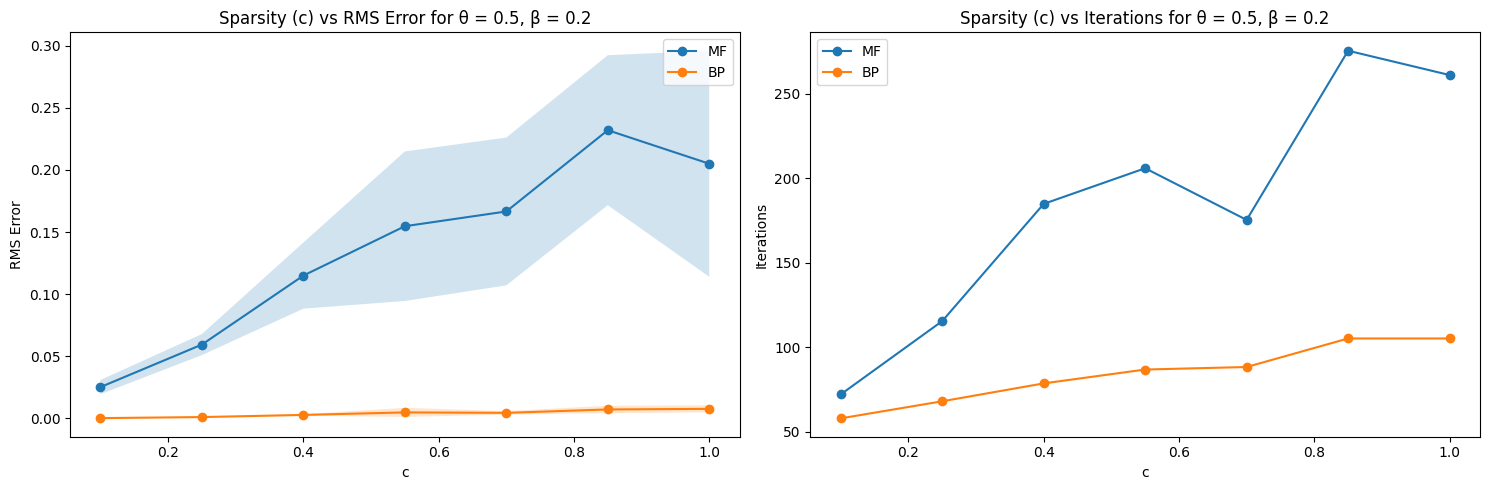

In [ ]:

index_theta = 0
index_beta = 0
print(f'Plots for theta with index = {index_theta}')

error_bp = theta_results_bp_c[index_theta][:, index_beta]
error_mf = theta_results_mf_c[index_theta][:,index_beta]

iter_bp = iterations_results_bp_c[index_theta][:,index_beta]
iter_mf = iterations_results_mf_c[index_theta][:, index_beta]

# Calculate standard deviation for both errors and iterations
std_error_bp = theta_dev_bp_c[index_theta][:,index_beta]
std_error_mf = theta_dev_mf_c[index_theta][:,index_beta]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('c')
plt.ylabel('RMS Error')
plt.title('Sparsity (c) vs RMS Error for θ = 0.5, β = 0.2')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')
plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('c')
plt.ylabel('Iterations')
plt.title('Sparsity (c) vs Iterations for θ = 0.5, β = 0.2')
plt.legend()

plt.tight_layout()
plt.show()


Plots for theta with index = 0


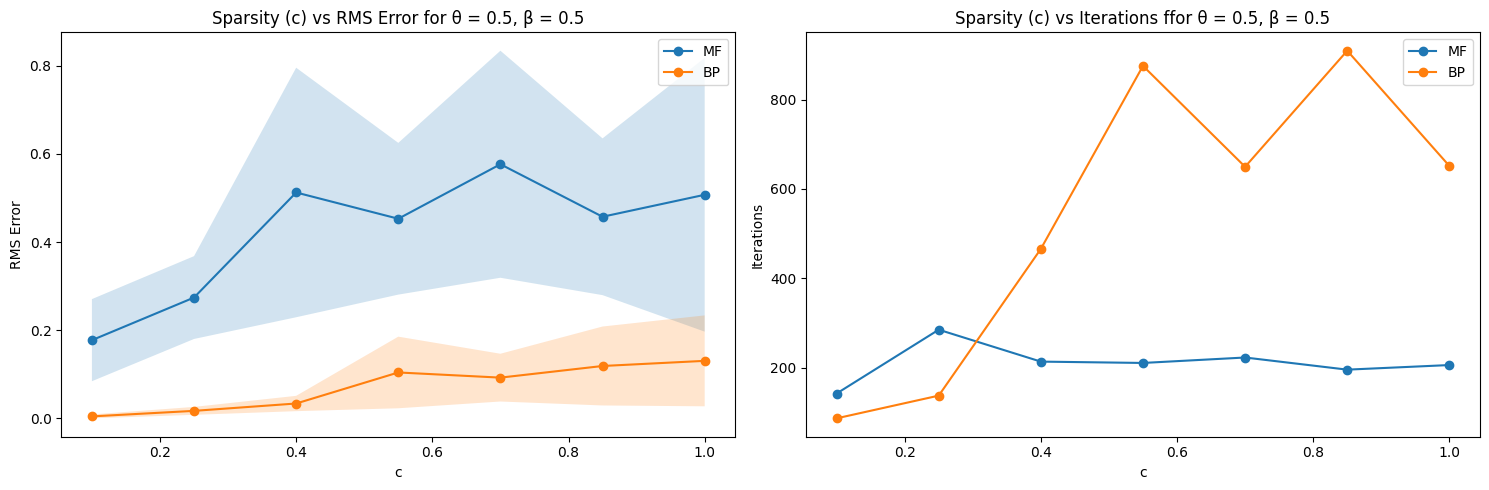

In [ ]:

index_theta = 0
index_beta = 1
print(f'Plots for theta with index = {index_theta}')

error_bp = theta_results_bp_c[index_theta][:, index_beta]
error_mf = theta_results_mf_c[index_theta][:,index_beta]

iter_bp = iterations_results_bp_c[index_theta][:,index_beta]
iter_mf = iterations_results_mf_c[index_theta][:, index_beta]

# Calculate standard deviation for both errors and iterations
std_error_bp = theta_dev_bp_c[index_theta][:,index_beta]
std_error_mf = theta_dev_mf_c[index_theta][:,index_beta]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('c')
plt.ylabel('RMS Error')
plt.title('Sparsity (c) vs RMS Error for θ = 0.5, β = 0.5')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')
plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('c')
plt.ylabel('Iterations')
plt.title('Sparsity (c) vs Iterations ffor θ = 0.5, β = 0.5')
plt.legend()

plt.tight_layout()
plt.show()


## Results as a function of c for $\theta = 0.8$

In [ ]:
n=20
n_iter = 10

# Initialize the range of beta and c values and the lists to store RMS errors and iterations
line_values = np.linspace(0.1, 1, 7)

# Possible values of theta: 0,1 - 0,5 - 0.9
theta_values = [0.8]

# Values of beta to test
betas = np.linspace(0.2, 0.5, num=2)



theta_results_bp_c = []
theta_results_mf_c = []
theta_dev_bp_c = []
theta_dev_mf_c = []
iterations_results_bp_c = []
iterations_results_mf_c = []


for k, theta_val in enumerate(theta_values):

  rms_errors_mf_c = np.zeros((line_values.shape[0], len(betas)))
  rms_errors_bp_c = np.zeros((line_values.shape[0], len(betas)))
  rms_dev_errors_mf_c = np.zeros((line_values.shape[0], len(betas)))
  rms_dev_errors_bp_c = np.zeros((line_values.shape[0], len(betas)))
  iterations_mf_c = np.zeros((line_values.shape[0], len(betas)))
  iterations_bp_c = np.zeros((line_values.shape[0], len(betas)))

  for i, val in enumerate(line_values):


    for j, beta in enumerate(betas):
      errors_for_beta_mf = []
      iter_for_beta_mf = []
      errors_for_beta_bp = []
      iter_for_beta_bp = []

      for _ in range(n_iter):
        print(f'Theta {theta_val} - c = {val} - beta = {beta} - iter {_}')
        w = get_Ising_model(fc=False, beta=beta, c1=val)
        th = np.ones(n) * theta_val
        sa = s_all(n) # all 2^n spin configurations
        Ea = 0.5 * np.sum(sa @ np.array(w) * sa, axis=1) + sa @ th
        Ea = np.exp(Ea)
        Z = np.sum(Ea)
        p_ex = Ea / Z  # probabilities of all 2^n configurations
        m_ex = sa.T @ p_ex  # exact mean values of n spins


        # Calculate the MF approximation
        m_mf, iter_mf = mean_field_approximation(w, th, n)
        rms_error_mf = calculate_rms_error(m_mf, m_ex,20)  # Calculate the RMS error
        errors_for_beta_mf.append(rms_error_mf)
        iter_for_beta_mf.append(iter_mf)


        # Calculate the BP approximation
        m_bp, iter_bp, _ = belief_propagation_approximation(w=w, th=th, n=n, smoothing = True, mu=0.5)
        rms_error_bp = calculate_rms_error(m_bp, m_ex,400)  # Calculate the RMS error
        errors_for_beta_bp.append(rms_error_bp)
        iter_for_beta_bp.append(iter_bp)

      rms_errors_mf_c[i,j] = np.mean(errors_for_beta_mf)
      rms_errors_bp_c[i,j] = np.mean(errors_for_beta_bp)

      rms_dev_errors_mf_c[i,j] = np.std(errors_for_beta_mf)
      rms_dev_errors_bp_c[i,j] = np.std(errors_for_beta_bp)

      iterations_mf_c[i,j] = np.mean(iter_for_beta_mf)
      iterations_bp_c[i,j] = np.mean(iter_for_beta_bp)

  theta_results_bp_c.append(rms_errors_bp_c)
  theta_results_mf_c.append(rms_errors_mf_c)
  theta_dev_bp_c.append(rms_dev_errors_bp_c)
  theta_dev_mf_c.append(rms_dev_errors_mf_c)
  iterations_results_bp_c.append(iterations_bp_c)
  iterations_results_mf_c.append(iterations_mf_c)



Theta 0.8 - c = 0.1 - beta = 0.2 - iter 0
Theta 0.8 - c = 0.1 - beta = 0.2 - iter 1
Theta 0.8 - c = 0.1 - beta = 0.2 - iter 2
Theta 0.8 - c = 0.1 - beta = 0.2 - iter 3
Theta 0.8 - c = 0.1 - beta = 0.2 - iter 4
Theta 0.8 - c = 0.1 - beta = 0.2 - iter 5
Theta 0.8 - c = 0.1 - beta = 0.2 - iter 6
Theta 0.8 - c = 0.1 - beta = 0.2 - iter 7
Theta 0.8 - c = 0.1 - beta = 0.2 - iter 8
Theta 0.8 - c = 0.1 - beta = 0.2 - iter 9
Theta 0.8 - c = 0.1 - beta = 0.5 - iter 0
Theta 0.8 - c = 0.1 - beta = 0.5 - iter 1
Theta 0.8 - c = 0.1 - beta = 0.5 - iter 2
Theta 0.8 - c = 0.1 - beta = 0.5 - iter 3
Theta 0.8 - c = 0.1 - beta = 0.5 - iter 4
Theta 0.8 - c = 0.1 - beta = 0.5 - iter 5
Theta 0.8 - c = 0.1 - beta = 0.5 - iter 6
Theta 0.8 - c = 0.1 - beta = 0.5 - iter 7
Theta 0.8 - c = 0.1 - beta = 0.5 - iter 8
Theta 0.8 - c = 0.1 - beta = 0.5 - iter 9
Theta 0.8 - c = 0.25 - beta = 0.2 - iter 0
Theta 0.8 - c = 0.25 - beta = 0.2 - iter 1
Theta 0.8 - c = 0.25 - beta = 0.2 - iter 2
Theta 0.8 - c = 0.25 - beta = 0

Plots for theta with index = 0
[[7.24061040e-05 9.82410322e-04]
 [1.59421935e-04 3.59611963e-03]
 [3.39252128e-04 1.75628459e-02]
 [7.74883869e-04 4.84577013e-02]
 [2.37769522e-03 2.48225960e-02]
 [1.53950238e-03 8.75098571e-02]
 [1.81899760e-03 1.13752039e-01]]
[array([[0.00014017, 0.00126021],
       [0.00052298, 0.00747178],
       [0.00156223, 0.01663555],
       [0.00236038, 0.06175333],
       [0.00367991, 0.03747363],
       [0.00416071, 0.08419259],
       [0.00536802, 0.11118246]])]


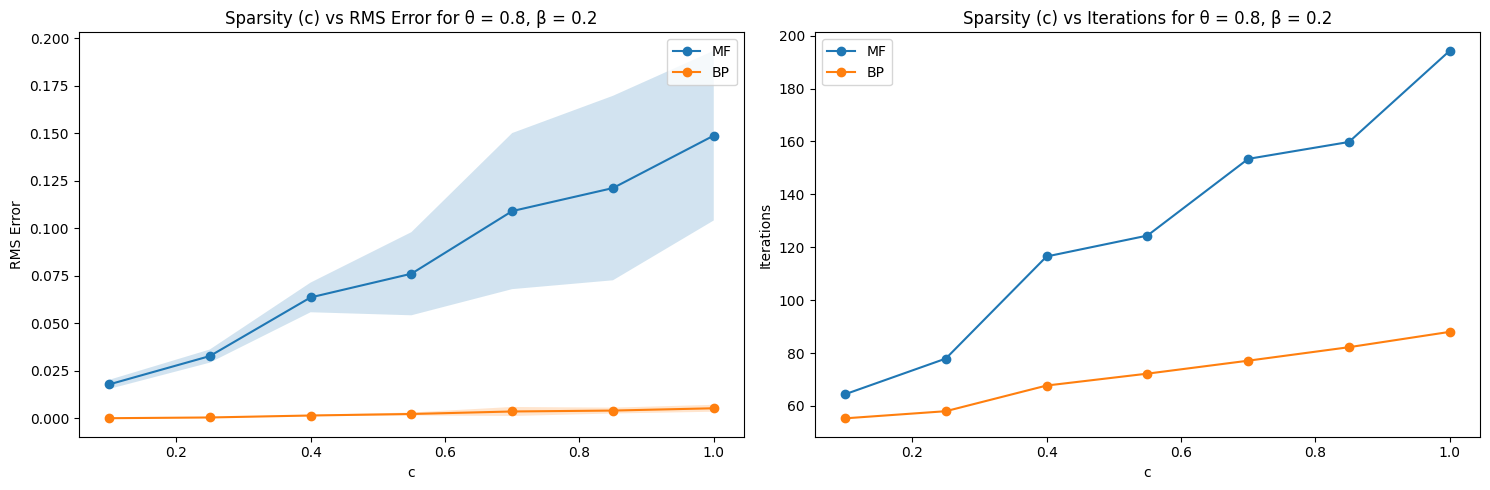

In [ ]:

index_theta = 0
index_beta = 0
print(f'Plots for theta with index = {index_theta}')

error_bp = theta_results_bp_c[index_theta][:,index_beta]
error_mf = theta_results_mf_c[index_theta][:,index_beta]

iter_bp = iterations_results_bp_c[index_theta][:,index_beta]
iter_mf = iterations_results_mf_c[index_theta][:, index_beta]
# Calculate standard deviation for both errors and iterations
std_error_bp =rms_dev_errors_bp_c[:,index_theta]
std_error_mf =rms_dev_errors_mf_c[:,index_theta]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('c')
plt.ylabel('RMS Error')
plt.title('Sparsity (c) vs RMS Error for θ = 0.8, β = 0.2')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')

plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('c')
plt.ylabel('Iterations')
plt.title('Sparsity (c) vs Iterations for θ = 0.8, β = 0.2')
plt.legend()

plt.tight_layout()
plt.show()


Plots for theta with index = 0
[0.02908589 0.07788349 0.16184126 0.21229711 0.22902715 0.38245932
 0.32577543]
[0.00098241 0.00359612 0.01756285 0.0484577  0.0248226  0.08750986
 0.11375204]


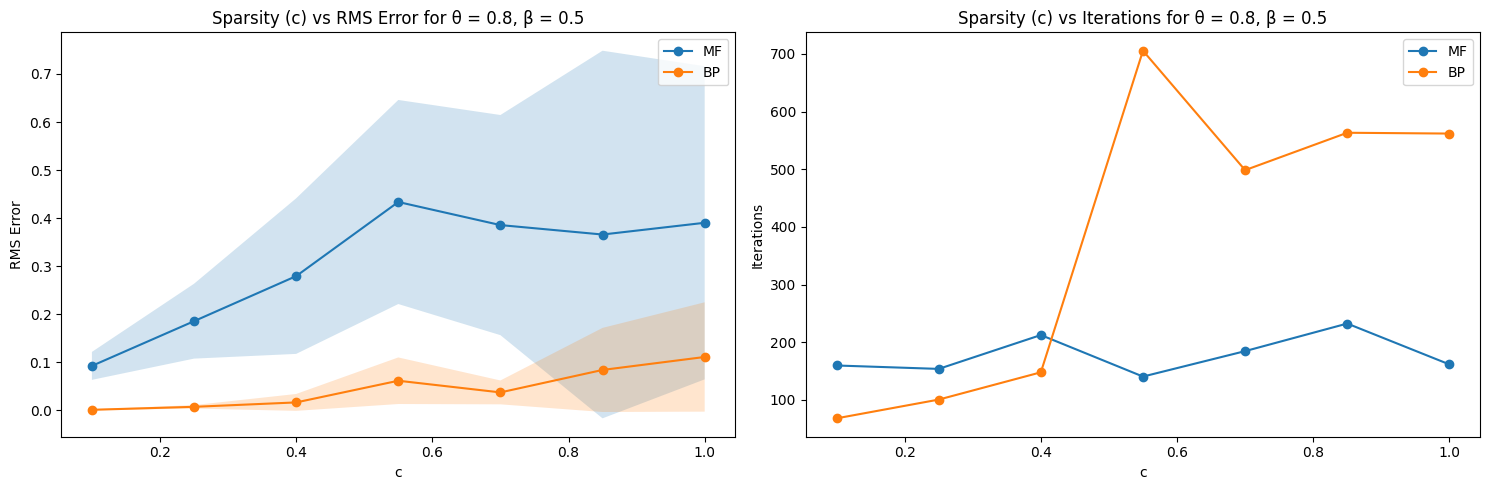

In [ ]:

index_theta = 0
index_beta = 1
print(f'Plots for theta with index = {index_theta}')

error_bp = theta_results_bp_c[index_theta][:, index_beta]
error_mf = theta_results_mf_c[index_theta][:,index_beta]

iter_bp = iterations_results_bp_c[index_theta][:,index_beta]
iter_mf = iterations_results_mf_c[index_theta][:, index_beta]

# Calculate standard deviation for both errors and iterations
std_error_bp = rms_dev_errors_bp_c[:,index_beta]
std_error_mf = rms_dev_errors_mf_c[:,index_beta]
print(std_error_mf)
print(std_error_bp)

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('c')
plt.ylabel('RMS Error')
plt.title('Sparsity (c) vs RMS Error for θ = 0.8, β = 0.5')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')

plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('c')
plt.ylabel('Iterations')
plt.title('Sparsity (c) vs Iterations for θ = 0.8, β = 0.5')
plt.legend()

plt.tight_layout()
plt.show()


## Results as a function of $\beta$ for $\theta = 0.1$

In [ ]:
n=20
n_iter = 10

# Initialize the range of beta and c values and the lists to store RMS errors and iterations
line_values = np.linspace(0.1, 1, 7)

# Possible values of theta: 0,1 - 0,5 - 0.9
theta_values = [0.1]

# Values of beta to test
cs = np.linspace(0.2, 0.5, num=2)



theta_results_bp_beta = []
theta_results_mf_beta = []
theta_dev_bp_beta= []
theta_dev_mf_beta = []
iterations_results_bp_beta = []
iterations_results_mf_beta = []


for k, theta_val in enumerate(theta_values):

  rms_errors_mf_b = np.zeros((line_values.shape[0], len(cs)))
  rms_errors_bp_b = np.zeros((line_values.shape[0], len(cs)))
  rms_dev_errors_mf_b = np.zeros((line_values.shape[0], len(cs)))
  rms_dev_errors_bp_b = np.zeros((line_values.shape[0], len(cs)))
  iterations_mf_b = np.zeros((line_values.shape[0], len(cs)))
  iterations_bp_b = np.zeros((line_values.shape[0], len(cs)))

  for i, val in enumerate(line_values):


    for j, c in enumerate(cs):
      errors_for_c_mf = []
      iter_for_c_mf = []
      errors_for_c_bp = []
      iter_for_c_bp = []

      for _ in range(n_iter):
        print(f'Theta {theta_val} - c = {val} - c = {c} - iter {_}')
        w = get_Ising_model(fc=False, beta=val, c1=c)
        th = np.ones(n) * theta_val
        sa = s_all(n) # all 2^n spin configurations
        Ea = 0.5 * np.sum(sa @ np.array(w) * sa, axis=1) + sa @ th
        Ea = np.exp(Ea)
        Z = np.sum(Ea)
        p_ex = Ea / Z  # probabilities of all 2^n configurations
        m_ex = sa.T @ p_ex  # exact mean values of n spins


        # Calculate the MF approximation
        m_mf, iter_mf = mean_field_approximation(w, th, n)
        rms_error_mf = calculate_rms_error(m_mf, m_ex,20)  # Calculate the RMS error
        errors_for_c_mf.append(rms_error_mf)
        iter_for_c_mf.append(iter_mf)


        # Calculate the BP approximation
        m_bp, iter_bp, _ = belief_propagation_approximation(w=w, th=th, n=n, smoothing = True, mu=0.5)
        rms_error_bp = calculate_rms_error(m_bp, m_ex,400)  # Calculate the RMS error
        errors_for_c_bp.append(rms_error_bp)
        iter_for_c_bp.append(iter_bp)

      rms_errors_mf_b[i,j] = np.mean(errors_for_c_mf)
      rms_errors_bp_b[i,j] = np.mean(errors_for_c_bp)

      rms_dev_errors_mf_b[i,j] = np.std(errors_for_c_mf)
      rms_dev_errors_bp_b[i,j] = np.std(errors_for_c_bp)

      iterations_mf_b[i,j] = np.mean(iter_for_c_mf)
      iterations_bp_b[i,j] = np.mean(iter_for_c_bp)

  theta_results_bp_beta.append(rms_errors_bp_b)
  theta_results_mf_beta.append(rms_errors_mf_b)
  theta_dev_bp_beta.append(rms_dev_errors_bp_b)
  theta_dev_mf_beta.append(rms_dev_errors_mf_b)
  iterations_results_bp_beta.append(iterations_bp_b)
  iterations_results_mf_beta.append(iterations_mf_b)



Theta 0.1 - c = 0.1 - c = 0.2 - iter 0
Theta 0.1 - c = 0.1 - c = 0.2 - iter 1
Theta 0.1 - c = 0.1 - c = 0.2 - iter 2
Theta 0.1 - c = 0.1 - c = 0.2 - iter 3
Theta 0.1 - c = 0.1 - c = 0.2 - iter 4
Theta 0.1 - c = 0.1 - c = 0.2 - iter 5
Theta 0.1 - c = 0.1 - c = 0.2 - iter 6
Theta 0.1 - c = 0.1 - c = 0.2 - iter 7
Theta 0.1 - c = 0.1 - c = 0.2 - iter 8
Theta 0.1 - c = 0.1 - c = 0.2 - iter 9
Theta 0.1 - c = 0.1 - c = 0.5 - iter 0
Theta 0.1 - c = 0.1 - c = 0.5 - iter 1
Theta 0.1 - c = 0.1 - c = 0.5 - iter 2
Theta 0.1 - c = 0.1 - c = 0.5 - iter 3
Theta 0.1 - c = 0.1 - c = 0.5 - iter 4
Theta 0.1 - c = 0.1 - c = 0.5 - iter 5
Theta 0.1 - c = 0.1 - c = 0.5 - iter 6
Theta 0.1 - c = 0.1 - c = 0.5 - iter 7
Theta 0.1 - c = 0.1 - c = 0.5 - iter 8
Theta 0.1 - c = 0.1 - c = 0.5 - iter 9
Theta 0.1 - c = 0.25 - c = 0.2 - iter 0
Theta 0.1 - c = 0.25 - c = 0.2 - iter 1
Theta 0.1 - c = 0.25 - c = 0.2 - iter 2
Theta 0.1 - c = 0.25 - c = 0.2 - iter 3
Theta 0.1 - c = 0.25 - c = 0.2 - iter 4
Theta 0.1 - c = 0.25

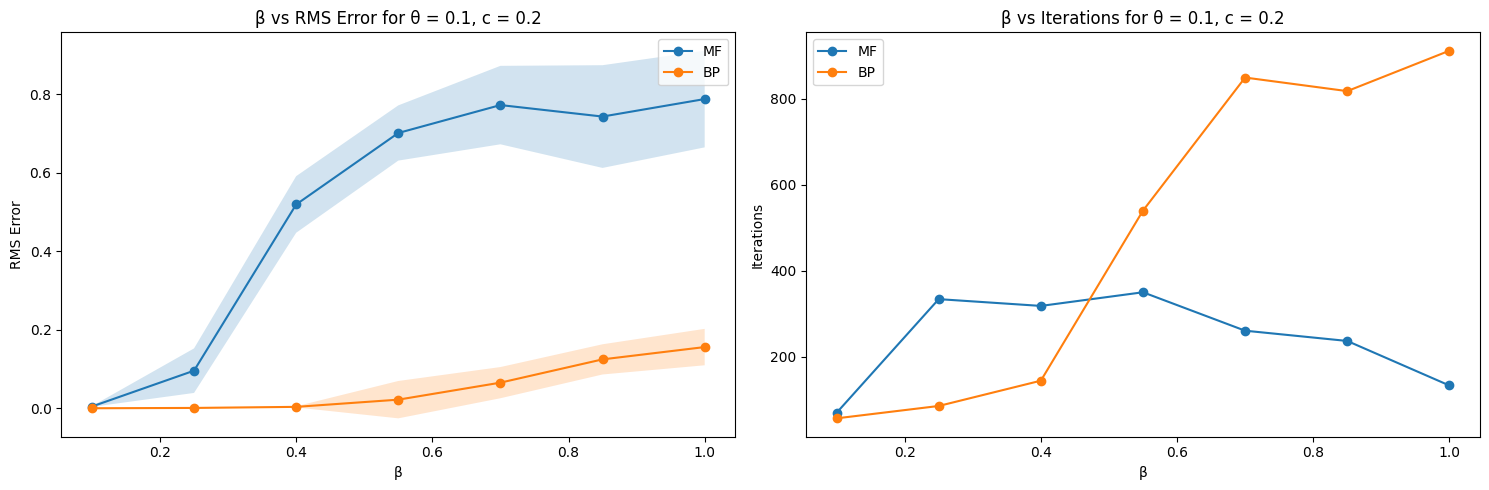

In [ ]:

index_theta = 0
index_c = 0
error_bp = theta_results_bp_beta[index_theta][:, index_c]
error_mf = theta_results_mf_beta[index_theta][:,index_c]

iter_bp = iterations_results_bp_beta[index_theta][:,index_c]
iter_mf = iterations_results_mf_beta[index_theta][:, index_c]

# Calculate standard deviation for both errors and iterations
std_error_bp = theta_dev_bp_beta[index_theta][:,index_c]
std_error_mf = theta_dev_mf_beta[index_theta][:,index_c]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('β')
plt.ylabel('RMS Error')
plt.title('β vs RMS Error for θ = 0.1, c = 0.2')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')

plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('β')
plt.ylabel('Iterations')
plt.title('β vs Iterations for θ = 0.1, c = 0.2')
plt.legend()

plt.tight_layout()
plt.show()


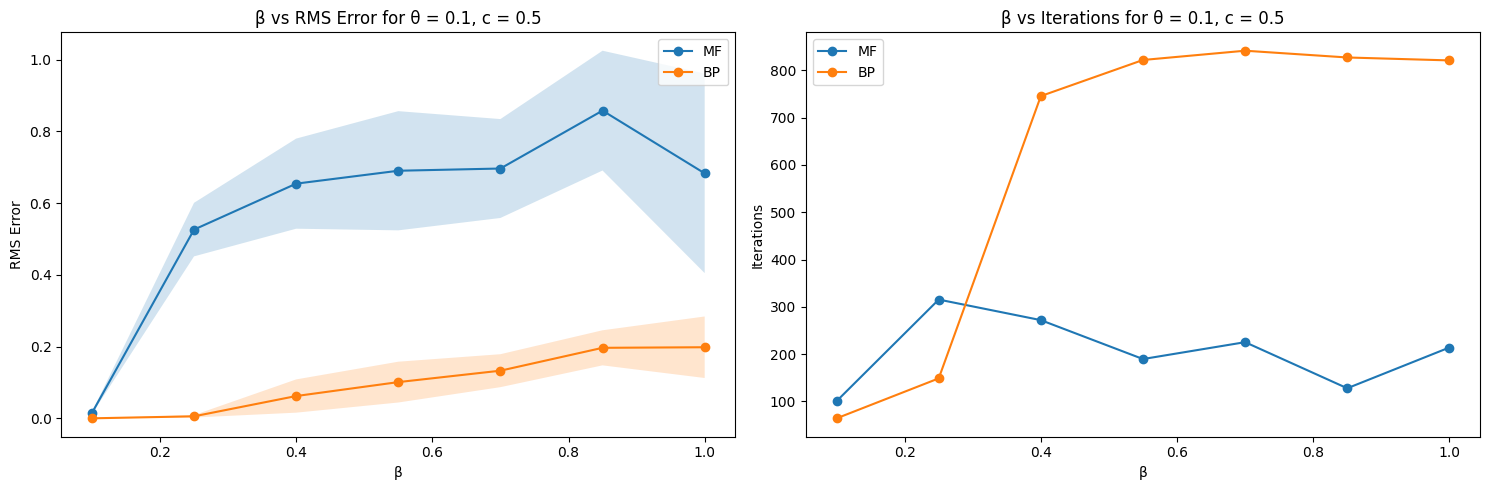

In [ ]:

index_theta = 0
index_c = 1
error_bp = theta_results_bp_beta[index_theta][:, index_c]
error_mf = theta_results_mf_beta[index_theta][:,index_c]

iter_bp = iterations_results_bp_beta[index_theta][:,index_c]
iter_mf = iterations_results_mf_beta[index_theta][:, index_c]

# Calculate standard deviation for both errors and iterations
std_error_bp = theta_dev_bp_beta[index_theta][:,index_c]
std_error_mf = theta_dev_mf_beta[index_theta][:,index_c]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('β')
plt.ylabel('RMS Error')
plt.title('β vs RMS Error for θ = 0.1, c = 0.5')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')

plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('β')
plt.ylabel('Iterations')
plt.title('β vs Iterations for θ = 0.1, c = 0.5')
plt.legend()

plt.tight_layout()
plt.show()


## Results as a function of $\beta$ for $\theta = 0.5$

In [ ]:
n=20
n_iter = 10

# Initialize the range of beta and c values and the lists to store RMS errors and iterations
line_values = np.linspace(0.1, 1, 7)

# Possible values of theta: 0,1 - 0,5 - 0.9
theta_values = [0.5]

# Values of beta to test
cs = np.linspace(0.2, 0.5, num=2)



theta_results_bp_beta = []
theta_results_mf_beta = []
theta_dev_bp_beta= []
theta_dev_mf_beta = []
iterations_results_bp_beta = []
iterations_results_mf_beta = []


for k, theta_val in enumerate(theta_values):

  rms_errors_mf_b = np.zeros((line_values.shape[0], len(cs)))
  rms_errors_bp_b = np.zeros((line_values.shape[0], len(cs)))
  rms_dev_errors_mf_b = np.zeros((line_values.shape[0], len(cs)))
  rms_dev_errors_bp_b = np.zeros((line_values.shape[0], len(cs)))
  iterations_mf_b = np.zeros((line_values.shape[0], len(cs)))
  iterations_bp_b = np.zeros((line_values.shape[0], len(cs)))

  for i, val in enumerate(line_values):


    for j, c in enumerate(cs):
      errors_for_c_mf = []
      iter_for_c_mf = []
      errors_for_c_bp = []
      iter_for_c_bp = []

      for _ in range(n_iter):
        print(f'Theta {theta_val} - c = {val} - c = {c} - iter {_}')
        w = get_Ising_model(fc=False, beta=val, c1=c)
        th = np.ones(n) * theta_val
        sa = s_all(n) # all 2^n spin configurations
        Ea = 0.5 * np.sum(sa @ np.array(w) * sa, axis=1) + sa @ th
        Ea = np.exp(Ea)
        Z = np.sum(Ea)
        p_ex = Ea / Z  # probabilities of all 2^n configurations
        m_ex = sa.T @ p_ex  # exact mean values of n spins


        # Calculate the MF approximation
        m_mf, iter_mf = mean_field_approximation(w, th, n)
        rms_error_mf = calculate_rms_error(m_mf, m_ex,20)  # Calculate the RMS error
        errors_for_c_mf.append(rms_error_mf)
        iter_for_c_mf.append(iter_mf)


        # Calculate the BP approximation
        m_bp, iter_bp, _ = belief_propagation_approximation(w=w, th=th, n=n, smoothing = True, mu=0.5)
        rms_error_bp = calculate_rms_error(m_bp, m_ex,400)  # Calculate the RMS error
        errors_for_c_bp.append(rms_error_bp)
        iter_for_c_bp.append(iter_bp)

      rms_errors_mf_b[i,j] = np.mean(errors_for_c_mf)
      rms_errors_bp_b[i,j] = np.mean(errors_for_c_bp)

      rms_dev_errors_mf_b[i,j] = np.std(errors_for_c_mf)
      rms_dev_errors_bp_b[i,j] = np.std(errors_for_c_bp)

      iterations_mf_b[i,j] = np.mean(iter_for_c_mf)
      iterations_bp_b[i,j] = np.mean(iter_for_c_bp)

  theta_results_bp_beta.append(rms_errors_bp_b)
  theta_results_mf_beta.append(rms_errors_mf_b)
  theta_dev_bp_beta.append(rms_dev_errors_bp_b)
  theta_dev_mf_beta.append(rms_dev_errors_mf_b)
  iterations_results_bp_beta.append(iterations_bp_b)
  iterations_results_mf_beta.append(iterations_mf_b)



Theta 0.5 - c = 0.1 - c = 0.2 - iter 0
Theta 0.5 - c = 0.1 - c = 0.2 - iter 1
Theta 0.5 - c = 0.1 - c = 0.2 - iter 2
Theta 0.5 - c = 0.1 - c = 0.2 - iter 3
Theta 0.5 - c = 0.1 - c = 0.2 - iter 4
Theta 0.5 - c = 0.1 - c = 0.2 - iter 5
Theta 0.5 - c = 0.1 - c = 0.2 - iter 6
Theta 0.5 - c = 0.1 - c = 0.2 - iter 7
Theta 0.5 - c = 0.1 - c = 0.2 - iter 8
Theta 0.5 - c = 0.1 - c = 0.2 - iter 9
Theta 0.5 - c = 0.1 - c = 0.5 - iter 0
Theta 0.5 - c = 0.1 - c = 0.5 - iter 1
Theta 0.5 - c = 0.1 - c = 0.5 - iter 2
Theta 0.5 - c = 0.1 - c = 0.5 - iter 3
Theta 0.5 - c = 0.1 - c = 0.5 - iter 4
Theta 0.5 - c = 0.1 - c = 0.5 - iter 5
Theta 0.5 - c = 0.1 - c = 0.5 - iter 6
Theta 0.5 - c = 0.1 - c = 0.5 - iter 7
Theta 0.5 - c = 0.1 - c = 0.5 - iter 8
Theta 0.5 - c = 0.1 - c = 0.5 - iter 9
Theta 0.5 - c = 0.25 - c = 0.2 - iter 0
Theta 0.5 - c = 0.25 - c = 0.2 - iter 1
Theta 0.5 - c = 0.25 - c = 0.2 - iter 2
Theta 0.5 - c = 0.25 - c = 0.2 - iter 3
Theta 0.5 - c = 0.25 - c = 0.2 - iter 4
Theta 0.5 - c = 0.25

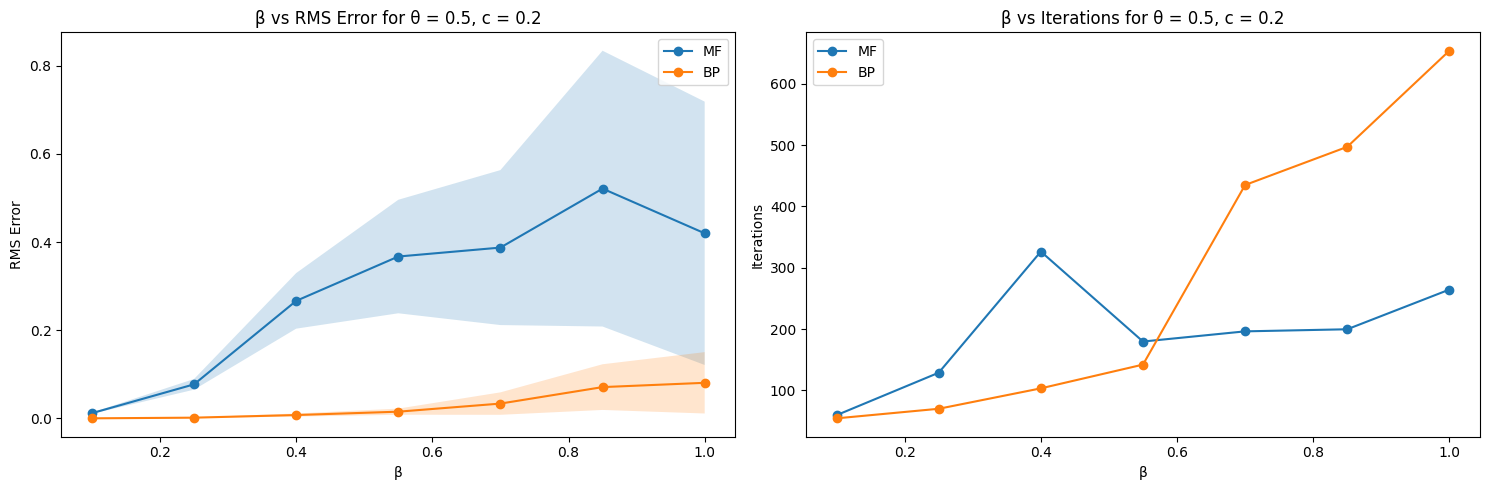

In [ ]:

index_theta = 0
index_c = 0
error_bp = theta_results_bp_beta[index_theta][:, index_c]
error_mf = theta_results_mf_beta[index_theta][:,index_c]

iter_bp = iterations_results_bp_beta[index_theta][:,index_c]
iter_mf = iterations_results_mf_beta[index_theta][:, index_c]

# Calculate standard deviation for both errors and iterations
std_error_bp = theta_dev_bp_beta[index_theta][:,index_c]
std_error_mf = theta_dev_mf_beta[index_theta][:,index_c]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('β')
plt.ylabel('RMS Error')
plt.title('β vs RMS Error for θ = 0.5, c = 0.2')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')

plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('β')
plt.ylabel('Iterations')
plt.title('β vs Iterations for θ = 0.5, c = 0.2')
plt.legend()

plt.tight_layout()
plt.show()


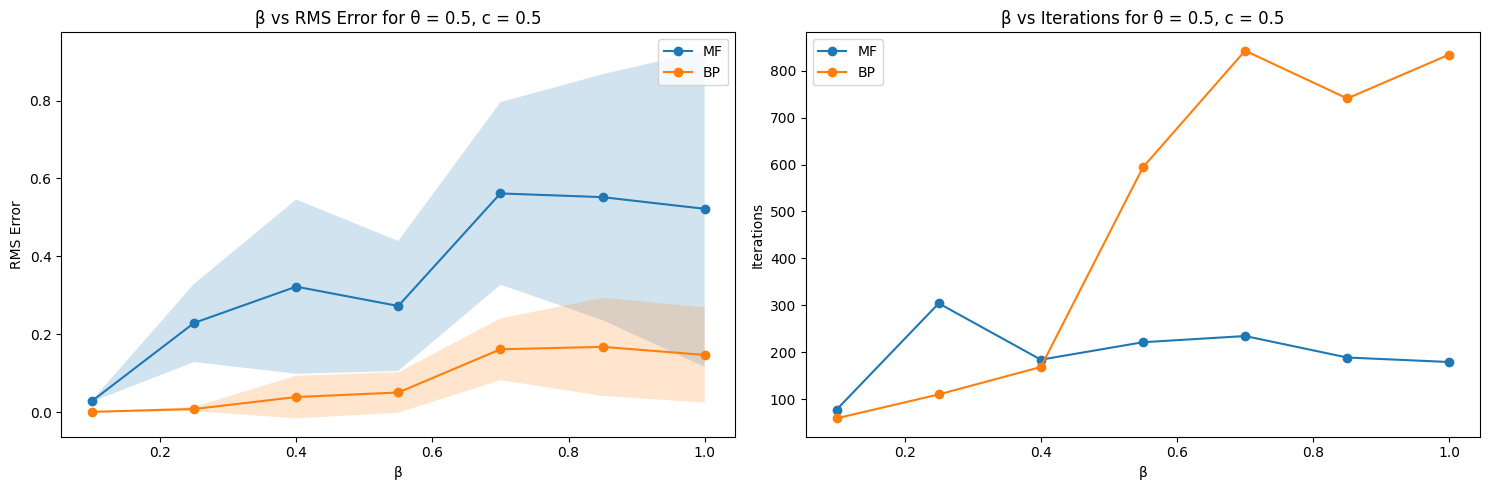

In [ ]:

index_theta = 0
index_c = 1
error_bp = theta_results_bp_beta[index_theta][:, index_c]
error_mf = theta_results_mf_beta[index_theta][:,index_c]

iter_bp = iterations_results_bp_beta[index_theta][:,index_c]
iter_mf = iterations_results_mf_beta[index_theta][:, index_c]

# Calculate standard deviation for both errors and iterations
std_error_bp = theta_dev_bp_beta[index_theta][:,index_c]
std_error_mf = theta_dev_mf_beta[index_theta][:,index_c]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('β')
plt.ylabel('RMS Error')
plt.title('β vs RMS Error for θ = 0.5, c = 0.5')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')

plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('β')
plt.ylabel('Iterations')
plt.title('β vs Iterations for θ = 0.5, c = 0.5')
plt.legend()

plt.tight_layout()
plt.show()


## Results as a function of $\beta$ for $\theta = 0.8$

In [ ]:
n=20
n_iter = 10

# Initialize the range of beta and c values and the lists to store RMS errors and iterations
line_values = np.linspace(0.1, 1, 7)

# Possible values of theta: 0,1 - 0,5 - 0.9
theta_values = [0.8]

# Values of beta to test
cs = np.linspace(0.2, 0.5, num=2)



theta_results_bp_beta = []
theta_results_mf_beta = []
theta_dev_bp_beta= []
theta_dev_mf_beta = []
iterations_results_bp_beta = []
iterations_results_mf_beta = []


for k, theta_val in enumerate(theta_values):

  rms_errors_mf_b = np.zeros((line_values.shape[0], len(cs)))
  rms_errors_bp_b = np.zeros((line_values.shape[0], len(cs)))
  rms_dev_errors_mf_b = np.zeros((line_values.shape[0], len(cs)))
  rms_dev_errors_bp_b = np.zeros((line_values.shape[0], len(cs)))
  iterations_mf_b = np.zeros((line_values.shape[0], len(cs)))
  iterations_bp_b = np.zeros((line_values.shape[0], len(cs)))

  for i, val in enumerate(line_values):


    for j, c in enumerate(cs):
      errors_for_c_mf = []
      iter_for_c_mf = []
      errors_for_c_bp = []
      iter_for_c_bp = []

      for _ in range(n_iter):
        print(f'Theta {theta_val} - c = {val} - c = {c} - iter {_}')
        w = get_Ising_model(fc=False, beta=val, c1=c)
        th = np.ones(n) * theta_val
        sa = s_all(n) # all 2^n spin configurations
        Ea = 0.5 * np.sum(sa @ np.array(w) * sa, axis=1) + sa @ th
        Ea = np.exp(Ea)
        Z = np.sum(Ea)
        p_ex = Ea / Z  # probabilities of all 2^n configurations
        m_ex = sa.T @ p_ex  # exact mean values of n spins


        # Calculate the MF approximation
        m_mf, iter_mf = mean_field_approximation(w, th, n)
        rms_error_mf = calculate_rms_error(m_mf, m_ex,20)  # Calculate the RMS error
        errors_for_c_mf.append(rms_error_mf)
        iter_for_c_mf.append(iter_mf)


        # Calculate the BP approximation
        m_bp, iter_bp, _ = belief_propagation_approximation(w=w, th=th, n=n, smoothing = True, mu=0.5)
        rms_error_bp = calculate_rms_error(m_bp, m_ex,400)  # Calculate the RMS error
        errors_for_c_bp.append(rms_error_bp)
        iter_for_c_bp.append(iter_bp)

      rms_errors_mf_b[i,j] = np.mean(errors_for_c_mf)
      rms_errors_bp_b[i,j] = np.mean(errors_for_c_bp)

      rms_dev_errors_mf_b[i,j] = np.std(errors_for_c_mf)
      rms_dev_errors_bp_b[i,j] = np.std(errors_for_c_bp)

      iterations_mf_b[i,j] = np.mean(iter_for_c_mf)
      iterations_bp_b[i,j] = np.mean(iter_for_c_bp)

  theta_results_bp_beta.append(rms_errors_bp_b)
  theta_results_mf_beta.append(rms_errors_mf_b)
  theta_dev_bp_beta.append(rms_dev_errors_bp_b)
  theta_dev_mf_beta.append(rms_dev_errors_mf_b)
  iterations_results_bp_beta.append(iterations_bp_b)
  iterations_results_mf_beta.append(iterations_mf_b)



Theta 0.8 - c = 0.1 - c = 0.2 - iter 0
Theta 0.8 - c = 0.1 - c = 0.2 - iter 1
Theta 0.8 - c = 0.1 - c = 0.2 - iter 2
Theta 0.8 - c = 0.1 - c = 0.2 - iter 3
Theta 0.8 - c = 0.1 - c = 0.2 - iter 4
Theta 0.8 - c = 0.1 - c = 0.2 - iter 5
Theta 0.8 - c = 0.1 - c = 0.2 - iter 6
Theta 0.8 - c = 0.1 - c = 0.2 - iter 7
Theta 0.8 - c = 0.1 - c = 0.2 - iter 8
Theta 0.8 - c = 0.1 - c = 0.2 - iter 9
Theta 0.8 - c = 0.1 - c = 0.5 - iter 0
Theta 0.8 - c = 0.1 - c = 0.5 - iter 1
Theta 0.8 - c = 0.1 - c = 0.5 - iter 2
Theta 0.8 - c = 0.1 - c = 0.5 - iter 3
Theta 0.8 - c = 0.1 - c = 0.5 - iter 4
Theta 0.8 - c = 0.1 - c = 0.5 - iter 5
Theta 0.8 - c = 0.1 - c = 0.5 - iter 6
Theta 0.8 - c = 0.1 - c = 0.5 - iter 7
Theta 0.8 - c = 0.1 - c = 0.5 - iter 8
Theta 0.8 - c = 0.1 - c = 0.5 - iter 9
Theta 0.8 - c = 0.25 - c = 0.2 - iter 0
Theta 0.8 - c = 0.25 - c = 0.2 - iter 1
Theta 0.8 - c = 0.25 - c = 0.2 - iter 2
Theta 0.8 - c = 0.25 - c = 0.2 - iter 3
Theta 0.8 - c = 0.25 - c = 0.2 - iter 4
Theta 0.8 - c = 0.25

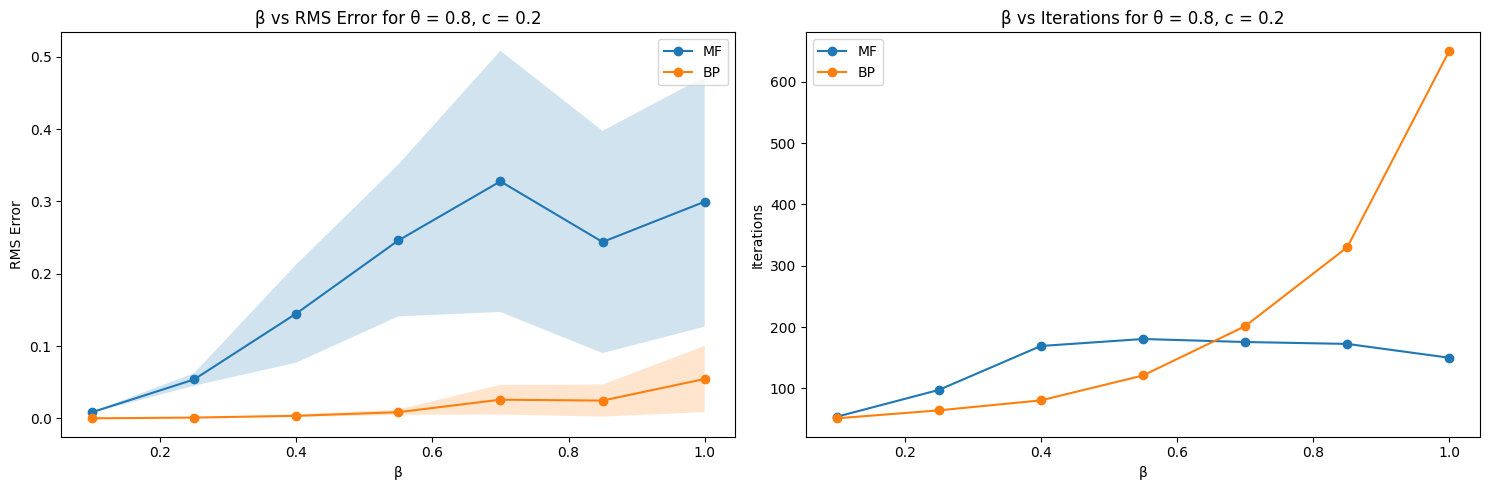

In [ ]:

index_theta = 0
index_c = 0
error_bp = theta_results_bp_beta[index_theta][:, index_c]
error_mf = theta_results_mf_beta[index_theta][:,index_c]

iter_bp = iterations_results_bp_beta[index_theta][:,index_c]
iter_mf = iterations_results_mf_beta[index_theta][:, index_c]

# Calculate standard deviation for both errors and iterations
std_error_bp = theta_dev_bp_beta[index_theta][:,index_c]
std_error_mf = theta_dev_mf_beta[index_theta][:,index_c]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('β')
plt.ylabel('RMS Error')
plt.title('β vs RMS Error for θ = 0.8, c = 0.2')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')

plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('β')
plt.ylabel('Iterations')
plt.title('β vs Iterations for θ = 0.8, c = 0.2')
plt.legend()

plt.tight_layout()
plt.show()


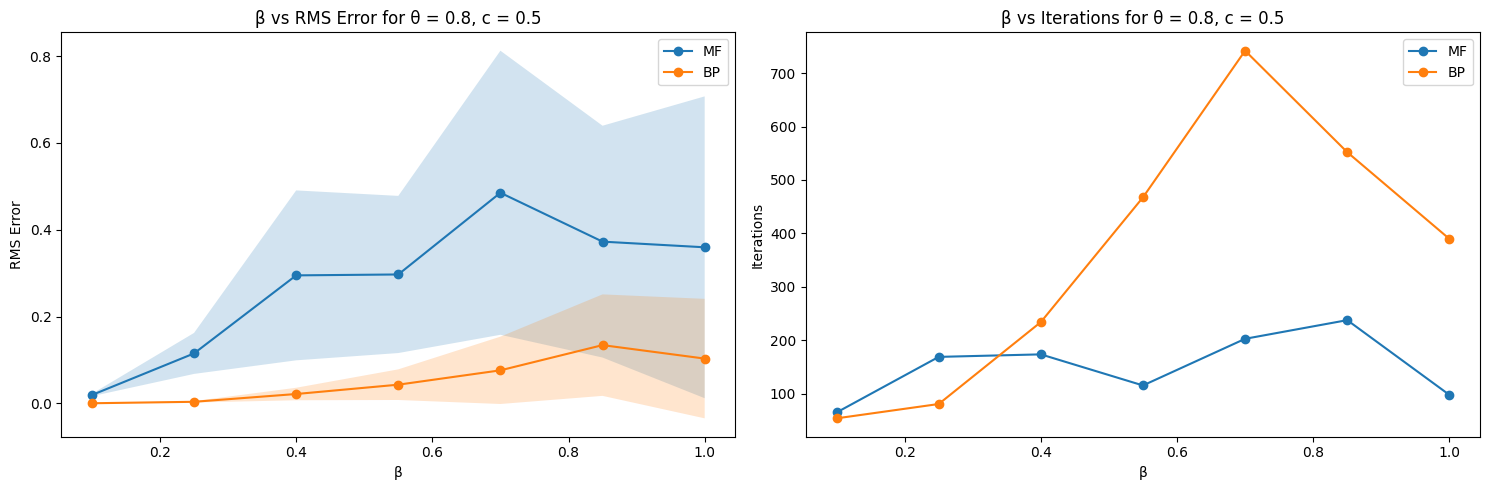

In [ ]:

index_theta = 0
index_c = 1
error_bp = theta_results_bp_beta[index_theta][:, index_c]
error_mf = theta_results_mf_beta[index_theta][:,index_c]

iter_bp = iterations_results_bp_beta[index_theta][:,index_c]
iter_mf = iterations_results_mf_beta[index_theta][:, index_c]

# Calculate standard deviation for both errors and iterations
std_error_bp = theta_dev_bp_beta[index_theta][:,index_c]
std_error_mf = theta_dev_mf_beta[index_theta][:,index_c]

# Plot the RMS error and Iterations as subplots
plt.figure(figsize=(15, 5))

# Subplot 1: RMS Error
plt.subplot(1, 2, 1)
plt.plot(line_values, error_mf, label='MF', marker='o')
plt.fill_between(line_values, error_mf - std_error_mf, error_mf + std_error_mf, alpha=0.2)

plt.plot(line_values, error_bp, label='BP', marker='o')
plt.fill_between(line_values, error_bp - std_error_bp, error_bp + std_error_bp, alpha=0.2)

plt.xlabel('β')
plt.ylabel('RMS Error')
plt.title('β vs RMS Error for θ = 0.8, c = 0.5')
plt.legend()

# Subplot 2: Iterations
plt.subplot(1, 2, 2)
plt.plot(line_values, iter_mf, label='MF', marker='o')

plt.plot(line_values, iter_bp, label='BP', marker='o')

plt.xlabel('β')
plt.ylabel('Iterations')
plt.title('β vs Iterations for θ = 0.8, c = 0.5')
plt.legend()

plt.tight_layout()
plt.show()
